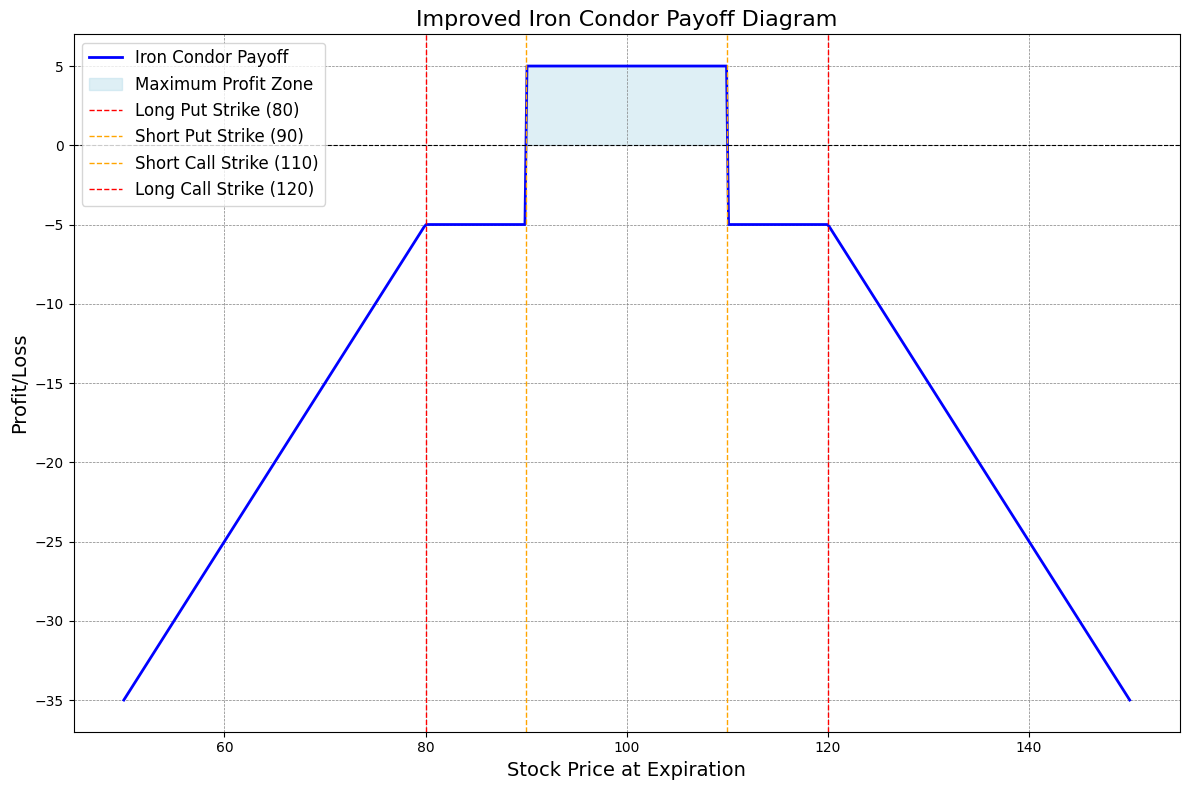

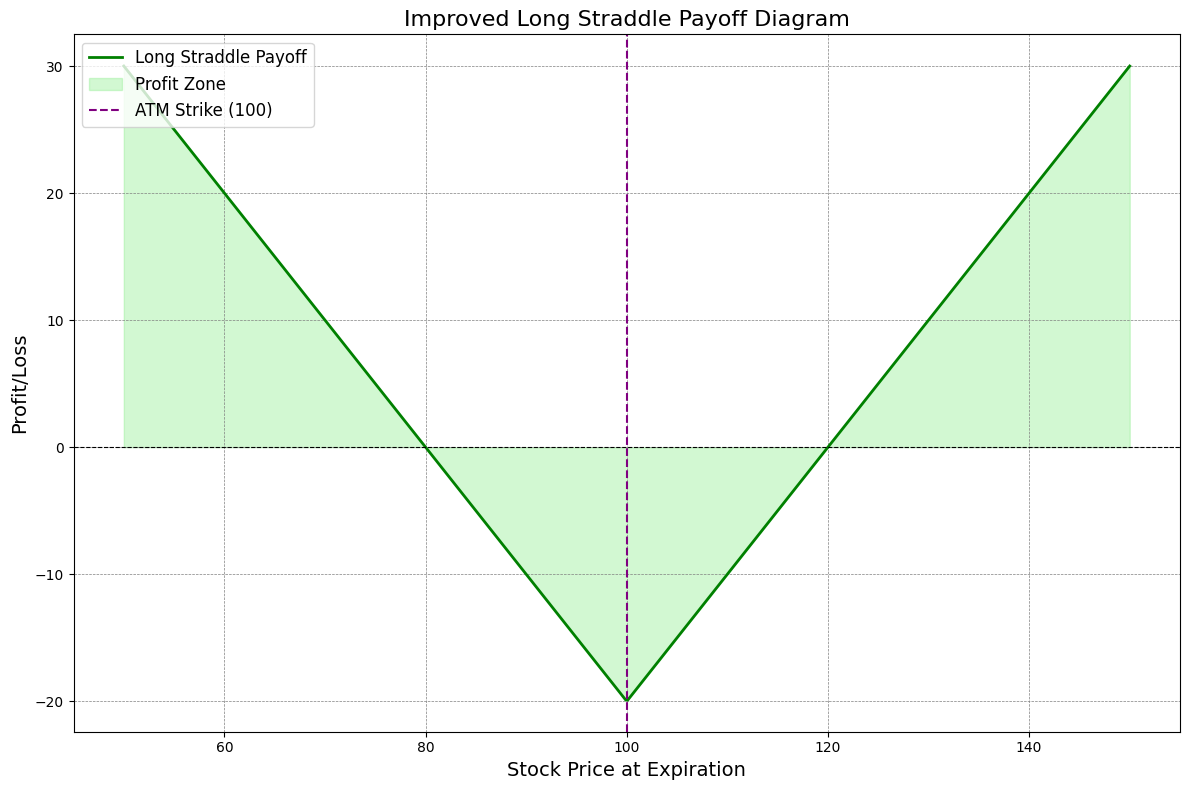

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tools

# Create stock price range
stock_prices = np.linspace(50, 150, 500)

# Iron Condor Parameters
short_call_strike = 110
long_call_strike = 120
short_put_strike = 90
long_put_strike = 80
premium_iron_condor = 5  # net premium received

# Long Straddle Parameters
atm_strike = 100
call_premium = 10
put_premium = 10

# Calculate Iron Condor Payoff
iron_condor_payoff = np.piecewise(
    stock_prices,
    [
        stock_prices <= long_put_strike,
        (stock_prices > long_put_strike) & (stock_prices <= short_put_strike),
        (stock_prices > short_put_strike) & (stock_prices <= short_call_strike),
        (stock_prices > short_call_strike) & (stock_prices <= long_call_strike),
        stock_prices > long_call_strike,
    ],
    [
        lambda x: -premium_iron_condor + (x - long_put_strike),
        lambda x: -premium_iron_condor,
        lambda x: premium_iron_condor,
        lambda x: -premium_iron_condor,
        lambda x: -premium_iron_condor - (x - long_call_strike),
    ],
)

# Calculate Long Straddle Payoff
long_straddle_payoff = (
    np.maximum(stock_prices - atm_strike, 0) - call_premium +
    np.maximum(atm_strike - stock_prices, 0) - put_premium
)

# Plot Improved Iron Condor Payoff
plt.figure(figsize=(12, 8))
plt.plot(stock_prices, iron_condor_payoff, label="Iron Condor Payoff", color="blue", linewidth=2)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.fill_between(
    stock_prices,
    0,
    iron_condor_payoff,
    where=(stock_prices > short_put_strike) & (stock_prices < short_call_strike),
    color="lightblue",
    alpha=0.4,
    label="Maximum Profit Zone",
)

# Annotate strike prices for Iron Condor
plt.axvline(long_put_strike, color="red", linestyle="--", linewidth=1, label="Long Put Strike (80)")
plt.axvline(short_put_strike, color="orange", linestyle="--", linewidth=1, label="Short Put Strike (90)")
plt.axvline(short_call_strike, color="orange", linestyle="--", linewidth=1, label="Short Call Strike (110)")
plt.axvline(long_call_strike, color="red", linestyle="--", linewidth=1, label="Long Call Strike (120)")

# Add labels and title for Iron Condor
plt.title("Improved Iron Condor Payoff Diagram", fontsize=16)
plt.xlabel("Stock Price at Expiration", fontsize=14)
plt.ylabel("Profit/Loss", fontsize=14)
plt.legend(fontsize=12, loc="upper left")
plt.grid(color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Show Iron Condor plot
plt.show()

# Plot Improved Long Straddle Payoff
plt.figure(figsize=(12, 8))
plt.plot(stock_prices, long_straddle_payoff, label="Long Straddle Payoff", color="green", linewidth=2)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.fill_between(
    stock_prices,
    0,
    long_straddle_payoff,
    where=(stock_prices < atm_strike) | (stock_prices > atm_strike),
    color="lightgreen",
    alpha=0.4,
    label="Profit Zone",
)

# Annotate strike prices for Long Straddle
plt.axvline(atm_strike, color="purple", linestyle="--", linewidth=1.5, label="ATM Strike (100)")

# Add labels and title for Long Straddle
plt.title("Improved Long Straddle Payoff Diagram", fontsize=16)
plt.xlabel("Stock Price at Expiration", fontsize=14)
plt.ylabel("Profit/Loss", fontsize=14)
plt.legend(fontsize=12, loc="upper left")
plt.grid(color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Show Long Straddle plot
plt.show()


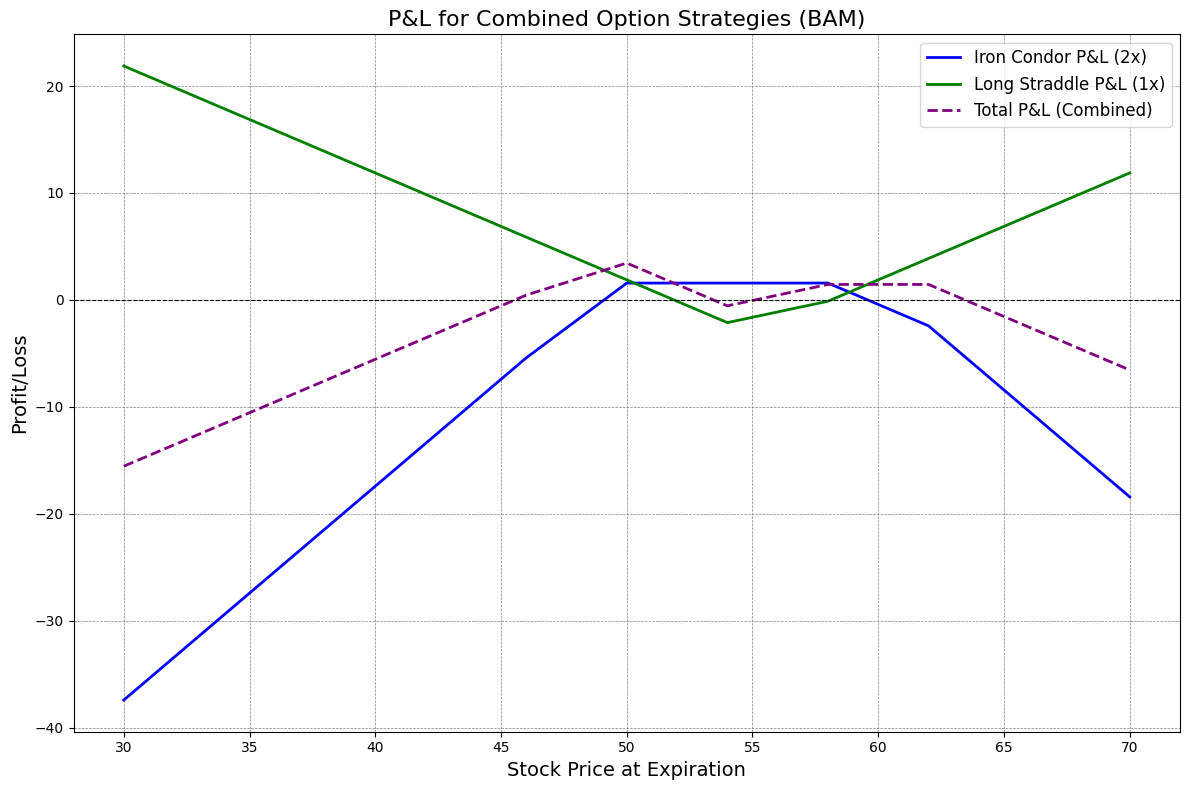

In [13]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

# Black-Scholes option pricing formula
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    S: Current stock price
    K: Strike price
    T: Time to expiration (in years)
    r: Risk-free rate (annualized)
    sigma: Volatility (annualized)
    option_type: "call" or "put"
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

# Parameters
S = 54.64  # Current stock price (BAM)
T = 30 / 365  # Time to expiration in years (30 days)
r = 0.05  # Annualized risk-free rate (5%)
sigma = 0.25  # Annualized volatility (25%)

# Iron Condor strikes and premiums
iron_condor_strikes = {"long_put": 49.5, "short_put": 52, "short_call": 57.5, "long_call": 60}
iron_condor_premiums = {
    "long_put": black_scholes(S, iron_condor_strikes["long_put"], T, r, sigma, "put"),
    "short_put": black_scholes(S, iron_condor_strikes["short_put"], T, r, sigma, "put"),
    "short_call": black_scholes(S, iron_condor_strikes["short_call"], T, r, sigma, "call"),
    "long_call": black_scholes(S, iron_condor_strikes["long_call"], T, r, sigma, "call"),
}
iron_condor_net_premium = (
    iron_condor_premiums["short_put"] - iron_condor_premiums["long_put"]
    + iron_condor_premiums["short_call"] - iron_condor_premiums["long_call"]
)

# Long Straddle premiums
atm_strike = 55  # At-the-money strike price
straddle_call_premium = black_scholes(S, atm_strike, T, r, sigma, "call")
straddle_put_premium = black_scholes(S, atm_strike, T, r, sigma, "put")
straddle_total_premium = straddle_call_premium + straddle_put_premium

# Simulate P&L for different stock prices
stock_prices = np.linspace(30, 70, 11)
iron_condor_pnl = []
straddle_pnl = []

for price in stock_prices:
    # Iron Condor P&L
    if price <= iron_condor_strikes["long_put"]:
        iron_condor_pnl.append(iron_condor_net_premium - (iron_condor_strikes["long_put"] - price))
    elif iron_condor_strikes["long_put"] < price <= iron_condor_strikes["short_put"]:
        iron_condor_pnl.append(iron_condor_net_premium)
    elif iron_condor_strikes["short_put"] < price <= iron_condor_strikes["short_call"]:
        iron_condor_pnl.append(iron_condor_net_premium)
    elif iron_condor_strikes["short_call"] < price <= iron_condor_strikes["long_call"]:
        iron_condor_pnl.append(iron_condor_net_premium)
    else:
        iron_condor_pnl.append(iron_condor_net_premium - (price - iron_condor_strikes["long_call"]))

    # Long Straddle P&L
    straddle_pnl.append(
        max(price - atm_strike, 0) + max(atm_strike - price, 0) - straddle_total_premium
    )

# Adjust P&L for 2 Iron Condors and 1 Straddle
iron_condor_pnl_adjusted = [2 * pnl for pnl in iron_condor_pnl]
straddle_pnl_adjusted = straddle_pnl  # 1 Straddle, no adjustment needed

# Create a DataFrame for the adjusted results
adjusted_pnl_table = pd.DataFrame({
    "Stock Price at Expiration": stock_prices,
    "Iron Condor P&L (2x)": iron_condor_pnl_adjusted,
    "Long Straddle P&L (1x)": straddle_pnl_adjusted,
    "Total P&L": [iron + straddle for iron, straddle in zip(iron_condor_pnl_adjusted, straddle_pnl_adjusted)],
})

# Plot P&L for the combined strategy
plt.figure(figsize=(12, 8))

# Plot individual and total P&L
plt.plot(stock_prices, iron_condor_pnl_adjusted, label="Iron Condor P&L (2x)", color="blue", linewidth=2)
plt.plot(stock_prices, straddle_pnl_adjusted, label="Long Straddle P&L (1x)", color="green", linewidth=2)
plt.plot(stock_prices, adjusted_pnl_table["Total P&L"], label="Total P&L (Combined)", color="purple", linewidth=2, linestyle="--")

# Add horizontal line for breakeven
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)

# Labels and Title
plt.title("P&L for Combined Option Strategies (BAM)", fontsize=16)
plt.xlabel("Stock Price at Expiration", fontsize=14)
plt.ylabel("Profit/Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Show plot
plt.show()


In [15]:
# Optimized parameters for the Iron Condor and Straddle
optimized_iron_condor_strikes = {"long_put": 50, "short_put": 53, "short_call": 57, "long_call": 59}
optimized_straddle_strikes = {"put": 53, "call": 57}  # Long Strangle as an alternative

# Calculate premiums for optimized Iron Condor
optimized_iron_condor_premiums = {
    "long_put": black_scholes(S, optimized_iron_condor_strikes["long_put"], T, r, sigma, "put"),
    "short_put": black_scholes(S, optimized_iron_condor_strikes["short_put"], T, r, sigma, "put"),
    "short_call": black_scholes(S, optimized_iron_condor_strikes["short_call"], T, r, sigma, "call"),
    "long_call": black_scholes(S, optimized_iron_condor_strikes["long_call"], T, r, sigma, "call"),
}
optimized_iron_condor_net_premium = (
    optimized_iron_condor_premiums["short_put"] - optimized_iron_condor_premiums["long_put"]
    + optimized_iron_condor_premiums["short_call"] - optimized_iron_condor_premiums["long_call"]
)

# Calculate premiums for optimized Long Strangle
optimized_strangle_premiums = {
    "put": black_scholes(S, optimized_straddle_strikes["put"], T, r, sigma, "put"),
    "call": black_scholes(S, optimized_straddle_strikes["call"], T, r, sigma, "call"),
}
optimized_strangle_total_premium = optimized_strangle_premiums["put"] + optimized_strangle_premiums["call"]

# Simulate P&L for different stock prices with optimized parameters
optimized_iron_condor_pnl = []
optimized_straddle_pnl = []

for price in stock_prices:
    # Optimized Iron Condor P&L
    if price <= optimized_iron_condor_strikes["long_put"]:
        optimized_iron_condor_pnl.append(
            optimized_iron_condor_net_premium - (optimized_iron_condor_strikes["long_put"] - price)
        )
    elif optimized_iron_condor_strikes["long_put"] < price <= optimized_iron_condor_strikes["short_put"]:
        optimized_iron_condor_pnl.append(optimized_iron_condor_net_premium)
    elif optimized_iron_condor_strikes["short_put"] < price <= optimized_iron_condor_strikes["short_call"]:
        optimized_iron_condor_pnl.append(optimized_iron_condor_net_premium)
    elif optimized_iron_condor_strikes["short_call"] < price <= optimized_iron_condor_strikes["long_call"]:
        optimized_iron_condor_pnl.append(optimized_iron_condor_net_premium)
    else:
        optimized_iron_condor_pnl.append(
            optimized_iron_condor_net_premium - (price - optimized_iron_condor_strikes["long_call"])
        )

    # Optimized Long Strangle P&L
    optimized_straddle_pnl.append(
        max(price - optimized_straddle_strikes["call"], 0)
        + max(optimized_straddle_strikes["put"] - price, 0)
        - optimized_strangle_total_premium
    )

# Adjust P&L for 2 Iron Condors and 1 Straddle
optimized_iron_condor_pnl_adjusted = [2 * pnl for pnl in optimized_iron_condor_pnl]
optimized_straddle_pnl_adjusted = optimized_straddle_pnl

# Create a DataFrame for the optimized results
optimized_pnl_table = pd.DataFrame({
    "Stock Price at Expiration": stock_prices,
    "Iron Condor P&L (2x)": optimized_iron_condor_pnl_adjusted,
    "Long Straddle P&L (1x)": optimized_straddle_pnl_adjusted,
    "Total P&L": [
        iron + straddle for iron, straddle in zip(optimized_iron_condor_pnl_adjusted, optimized_straddle_pnl_adjusted)
    ],
})

tools.display_dataframe_to_user(name="Optimized P&L Table for Combined BAM Option Strategies", dataframe=optimized_pnl_table)


AttributeError: module 'tools' has no attribute 'display_dataframe_to_user'

In [17]:
from tabulate import tabulate

# Convert the DataFrame to a table format
pnl_table = tabulate(
    optimized_pnl_table,
    headers="keys",
    tablefmt="grid",
    showindex=False,
    floatfmt=".2f"
)

# Print the table
print(pnl_table)


+-----------------------------+------------------------+--------------------------+-------------+
|   Stock Price at Expiration |   Iron Condor P&L (2x) |   Long Straddle P&L (1x) |   Total P&L |
+=============================+========================+==========================+=============+
|                       30.00 |                 -37.94 |                    21.47 |      -16.47 |
+-----------------------------+------------------------+--------------------------+-------------+
|                       34.00 |                 -29.94 |                    17.47 |      -12.47 |
+-----------------------------+------------------------+--------------------------+-------------+
|                       38.00 |                 -21.94 |                    13.47 |       -8.47 |
+-----------------------------+------------------------+--------------------------+-------------+
|                       42.00 |                 -13.94 |                     9.47 |       -4.47 |
+-------------------

In [16]:
import pandas as pd

# ... (rest of your code) ...

# Create a DataFrame for the optimized results
optimized_pnl_table = pd.DataFrame({
    "Stock Price at Expiration": stock_prices,
    "Iron Condor P&L (2x)": optimized_iron_condor_pnl_adjusted,
    "Long Straddle P&L (1x)": optimized_straddle_pnl_adjusted,
    "Total P&L": [
        iron + straddle for iron, straddle in zip(optimized_iron_condor_pnl_adjusted, optimized_straddle_pnl_adjusted)
    ],
})

# Display the DataFrame using pandas' display function
display(optimized_pnl_table)

# Alternatively, print the DataFrame to the console:
print(optimized_pnl_table)

,Stock Price at Expiration,Iron Condor P&L (2x),Long Straddle P&L (1x),Total P&L
0,30.0,-37.938612,21.468122,-16.47049
1,34.0,-29.938612,17.468122,-12.47049
2,38.0,-21.938612,13.468122,-8.47049
3,42.0,-13.938612,9.468122,-4.47049
4,46.0,-5.938612,5.468122,-0.47049
5,50.0,2.061388,1.468122,3.52951
6,54.0,2.061388,-1.531878,0.52951
7,58.0,2.061388,-0.531878,1.52951
8,62.0,-3.938612,3.468122,-0.47049
9,66.0,-11.938612,7.468122,-4.47049


    Stock Price at Expiration  Iron Condor P&L (2x)  Long Straddle P&L (1x)  \
0                        30.0            -37.938612               21.468122   
1                        34.0            -29.938612               17.468122   
2                        38.0            -21.938612               13.468122   
3                        42.0            -13.938612                9.468122   
4                        46.0             -5.938612                5.468122   
5                        50.0              2.061388                1.468122   
6                        54.0              2.061388               -1.531878   
7                        58.0              2.061388               -0.531878   
8                        62.0             -3.938612                3.468122   
9                        66.0            -11.938612                7.468122   
10                       70.0            -19.938612               11.468122   

    Total P&L  
0   -16.47049  
1   -12.47049  
2  

In [11]:
!pip install tools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tools: filename=tools-0.1.9-py3-none-any.whl size=46729 sha256=82e25ac4a29ca0cae40b406f113aefb675c18eac8af74e6790662f2a86bfe85b
  Stored in directory: /root/.cache/pip/wheels/c0/d0/70/a33bd4bed2af4f7038b038c16faab552cd0e9d9f4125223a71
  Created wheel for pytils: filename=pytils-0.4.1-py3-none-any.whl size=32875 sha256=bf80a1f9bf961f45ed32ff9ba218bdf4ef42c381e8ad04620c7783aabbf34efa
  Stored in directory: /root/.cache/pip/wheels/5a/eb/7c/3b6f0c25815749883152b2caca34c35dbaab13ec2864270cbd
Successfully built tools pytils
